# Deep neural net optimization
Hopefully, the performance of decision tree based models can be improved upon using a deep neural network. The plan is to start small and train on one geospatial bin only. If the model shows promise, it will then be scaled to make predictions for all of California.

### Goal: 
Optimize and test the performance of a deep neural network on one California geospatial bin.

### Plan:
1. Prep data from one geospatial bin for input into neural network
2. Generate 'Cassandra' model -> attempt to over fit and 'memorize' the training data. This will prove that the data is feature rich enough and a the network is complex enough to learn a function which successfully maps input to output.
3. If step 2 is successful, regularize model to increase generalizability.
4. If step 3 is successful, scale model to predict wilfire risk for all 410 California geospatial bins.

# Notebook setup

In [1]:
from numpy.random import seed
seed(42)

import logging

import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import pandas as pd

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model
from tensorflow.python.client import device_lib

# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective_2D #, plot_histogram
from skopt.utils import use_named_args
import imblearn

In [5]:
import helper_functions.config as config
import helper_functions.data_functions as data_functions
import helper_functions.plotting_functions as plotting_functions

In [6]:
import sys
print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print(f"Imbalanced-Learn {imblearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1
Imbalanced-Learn 0.7.0

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [7]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
training_data_file = config.training_data_file

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation
]

dim_learning_rate = Real(
    low=1e-5, 
    high=1e-1, 
    prior='log-uniform',
    name='learning_rate'
)

dim_hidden_layers = Integer(
    low=5,
    high=20, 
    name='hidden_layers'
)

dim_neurons_per_layer = Integer(
    low=10, 
    high=200, 
    name='neurons_per_layer'
)

dim_dropout_rate = Real(
    low=0.01, 
    high=0.5, 
    name='dropout_rate'
)

dim_l2_lambda = Real(
    low=0.001, 
    high=0.1, 
    name='l2_lambda'
)

dim_class_0_weight = Real(
    low=0.01,
    high=10,
    name='class_0_weight'
)

dim_class_1_weight = Real(
    low=10,
    high=50,
    name="class_1_weight"
)

dimensions = [
    dim_learning_rate,
    dim_hidden_layers,
    dim_neurons_per_layer,
    dim_dropout_rate,
    dim_l2_lambda,
    dim_class_0_weight,
    dim_class_1_weight
]

default_parameters = [0.1, 10, 10, 0.25, 0.05, 0.2, 15]

path_best_model = './trained_models/best_skopt_MLP.keras'
best_matthews_correlation = -1.0

In [9]:
training_data = pd.read_parquet(training_data_file)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 41 columns):
 #   Column             Dtype         
---  ------             -----         
 0   lat                float32       
 1   lon                float32       
 2   month              int32         
 3   apcp               float32       
 4   crain              int32         
 5   veg                float32       
 6   ignition           int32         
 7   mean_air_2m        float32       
 8   mean_rhum_2m       float32       
 9   mean_dpt_2m        float32       
 10  mean_pres_sfc      float32       
 11  mean_uwnd_10m      float32       
 12  mean_vwnd_10m      float32       
 13  mean_vis           float32       
 14  mean_cloud_cover   float32       
 15  max_air_2m         float32       
 16  max_rhum_2m        float32       
 17  max_dpt_2m         float32       
 18  max_pres_sfc       float32       
 19  max_uwnd_10m       float32       
 20  max_vwnd_10m       float

In [10]:
# pick columns to use
column_names = [
#     'date',
    'lat',      
    'lon',     
#     'month', 
    'apcp',
    'crain',
    'veg',
    'ignition',
    'mean_air_2m',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',  
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',
    'total_fires',  
    'range_air_2m',
    'range_rhum_2m',
    'range_dpt_2m',
    'range_pres_sfc',  
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover'
]

training_data = training_data[column_names]

In [11]:
# # One hot encode month

# months = [
#     'January',
#     'February',
#     'March',
#     'April',
#     'May',
#     'June',
#     'July',
#     'August',
#     'Septermber',
#     'October',
#     'November',
#     'December'
# ]

# # onehot encode month
# onehot_encoder = OneHotEncoder(sparse=False)

# # extract month from date column and convert to int
# month = np.array(pd.DatetimeIndex(training_data['date']).month).reshape(-1, 1)
# month = month.astype('int32')

# # onehot encode
# onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# # convert one hot encoded months to dataframe
# onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# # reset indexes, set dtypes and concatenate one hot encoded months 
# # back to orignal dataframe
# onehot_month_df.reset_index(drop = True, inplace = True)
# onehot_month_df = onehot_month_df.astype('int32')
# training_data.reset_index(drop = True, inplace = True)
# training_data = pd.concat([training_data, onehot_month_df], axis = 1)
# training_data.drop('date', axis=1, inplace=True)
# training_data.drop('month', axis=1, inplace=True)

In [12]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   lat                float32
 1   lon                float32
 2   apcp               float32
 3   crain              int32  
 4   veg                float32
 5   ignition           int32  
 6   mean_air_2m        float32
 7   mean_rhum_2m       float32
 8   mean_dpt_2m        float32
 9   mean_pres_sfc      float32
 10  mean_uwnd_10m      float32
 11  mean_vwnd_10m      float32
 12  mean_vis           float32
 13  mean_cloud_cover   float32
 14  total_fires        int32  
 15  range_air_2m       float32
 16  range_rhum_2m      float32
 17  range_dpt_2m       float32
 18  range_pres_sfc     float32
 19  range_uwnd_10m     float32
 20  range_vwnd_10m     float32
 21  range_vis          float32
 22  range_cloud_cover  float32
dtypes: float32(20), int32(3)
memory usage: 315.3 MB


In [13]:
features_to_normalize = [
    'lat',
    'lon',
#     'month', 
#     'crain', 
#     'apcp',
    'veg',
#    'ignition',  
    'mean_air_2m',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m',
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover',
    'total_fires'
]

# # use box-cox to enforce normal distributions on data
# qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
# normalized_training_data = pd.DataFrame(qt.fit_transform(training_data[features_to_normalize]), columns=features_to_normalize)
# training_data[features_to_normalize] = normalized_training_data

features_to_scale = [
    'lat',
    'lon',
#     'month', 
    'crain', 
    'apcp',
    'veg',
#    'ignition',  
    'mean_air_2m',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m',
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover',
    'total_fires'
]

# min-max scale data into (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_training_data = scaler.fit_transform(training_data[features_to_scale])
training_data[features_to_scale] = scaled_training_data

In [14]:
training_data.describe()

,lat,lon,apcp,crain,veg,ignition,mean_air_2m,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,...,mean_cloud_cover,total_fires,range_air_2m,range_rhum_2m,range_dpt_2m,range_pres_sfc,range_uwnd_10m,range_vwnd_10m,range_vis,range_cloud_cover
count,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,...,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06
mean,4.776817e-01,4.832622e-01,7.081924e-03,1.124021e-02,3.657558e-01,3.455034e-02,5.776794e-01,4.849543e-01,6.705456e-01,6.799393e-01,...,1.473068e-01,1.470948e-01,6.325755e-01,4.515565e-01,7.805736e-01,5.791890e-01,5.396113e-01,4.761195e-01,4.772917e-01,4.336286e-01
std,2.751332e-01,2.511656e-01,2.803147e-02,1.054224e-01,2.716639e-01,1.826380e-01,1.409262e-01,2.375180e-01,1.044227e-01,1.901032e-01,...,1.854523e-01,1.613129e-01,5.166429e-02,6.781742e-02,1.974568e-02,5.709192e-02,3.226250e-02,4.900296e-02,7.605245e-02,5.569041e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.483223e-01,2.876715e-01,0.000000e+00,0.000000e+00,9.796894e-02,0.000000e+00,4.811648e-01,2.822048e-01,6.001602e-01,5.605095e-01,...,1.578507e-02,3.593978e-02,5.969319e-01,4.130008e-01,7.722701e-01,5.453847e-01,5.209940e-01,4.473337e-01,4.765651e-01,4.003769e-01
50%,4.448885e-01,4.454158e-01,2.200836e-05,0.000000e+00,3.643967e-01,0.000000e+00,5.680739e-01,4.594186e-01,6.779693e-01,7.014374e-01,...,6.517876e-02,9.106362e-02,6.290313e-01,4.579220e-01,7.813376e-01,5.800617e-01,5.379839e-01,4.746955e-01,5.026869e-01,4.226350e-01
75%,7.079952e-01,6.945564e-01,3.964879e-04,0.000000e+00,5.209080e-01,0.000000e+00,6.753414e-01,6.817831e-01,7.485094e-01,8.317048e-01,...,2.144575e-01,1.996115e-01,6.656254e-01,4.952629e-01,7.894911e-01,6.141388e-01,5.569506e-01,5.035927e-01,5.027070e-01,4.628432e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [15]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   lat                float64
 1   lon                float64
 2   apcp               float64
 3   crain              float64
 4   veg                float64
 5   ignition           int32  
 6   mean_air_2m        float64
 7   mean_rhum_2m       float64
 8   mean_dpt_2m        float64
 9   mean_pres_sfc      float64
 10  mean_uwnd_10m      float64
 11  mean_vwnd_10m      float64
 12  mean_vis           float64
 13  mean_cloud_cover   float64
 14  total_fires        float64
 15  range_air_2m       float64
 16  range_rhum_2m      float64
 17  range_dpt_2m       float64
 18  range_pres_sfc     float64
 19  range_uwnd_10m     float64
 20  range_vwnd_10m     float64
 21  range_vis          float64
 22  range_cloud_cover  float64
dtypes: float64(22), int32(1)
memory usage: 617.0 MB


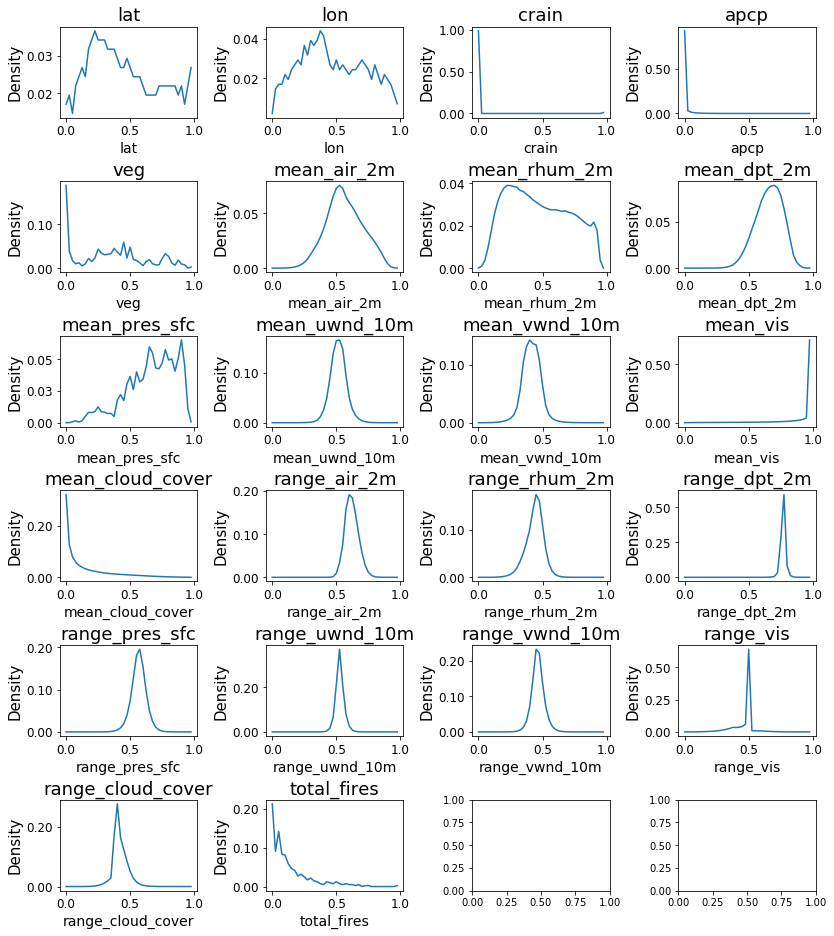

In [16]:
features_to_plot = [
    'lat',
    'lon',
#     'month', 
    'crain', 
    'apcp',
    'veg',
#    'ignition',  
    'mean_air_2m',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m',
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover',
    'total_fires'
]

# plot weather data distributions
left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 6
fig_cols = 4
plot_height = 15
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3),
    (5,0),(5,1),(5,2),(5,3)
]

xlabels = features_to_plot
ylabels = ['Density'] * len(features_to_plot)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_plot)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        features_to_plot[i], 
        features_to_plot[i], 
        features_to_plot[i], 
        ylabels[i]
    )

In [17]:
# Split labels and features.
train_labels = training_data.pop('ignition')
train_features = training_data

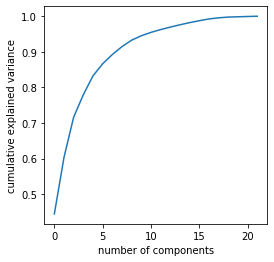

In [18]:
features_for_pca = [
    'lat',
    'lon',
#     'month',
    'crain', 
    'apcp',
    'veg', 
    'mean_air_2m',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_vis',
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m',
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover',
    'total_fires',
]

pca = PCA().fit(np.array(train_features[features_for_pca]))
fig = plt.figure(figsize = (4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [19]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(np.array(train_features[features_for_pca]))
principal_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

pca_result = pd.concat([principal_df, train_labels], axis = 1)
pca_result.head()

,principal component 1,principal component 2,principal component 3,ignition
0,-0.377818,0.402941,-0.249040,0
1,-0.349831,0.484845,-0.206642,0
2,-0.194146,0.848245,-0.087548,0
3,-0.253346,0.682110,-0.174187,0
4,-0.314955,0.565012,-0.200667,0


In [20]:
fire = pca_result[pca_result['ignition'] == 1]
no_fire = pca_result[pca_result['ignition'] == 0]

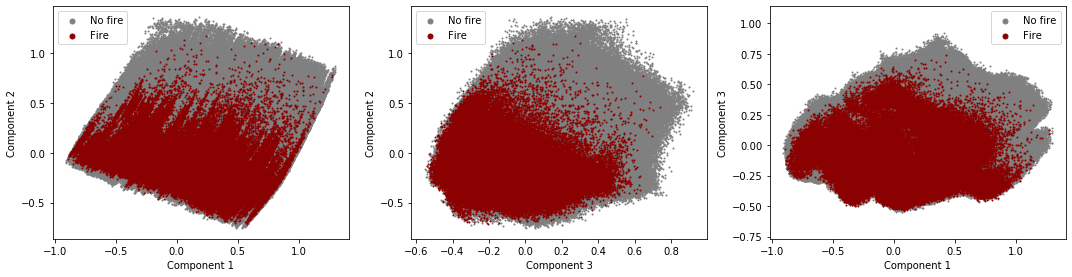

In [21]:
plt.subplots(1, 3, figsize=(15, 4))

plt.subplot(1, 3, 1)

plt.scatter(
    no_fire['principal component 1'], 
    no_fire['principal component 2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['principal component 1'], 
    fire['principal component 2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 2)

plt.scatter(
    no_fire['principal component 3'], 
    no_fire['principal component 2'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['principal component 3'], 
    fire['principal component 2'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 3')
plt.ylabel('Component 2')
plt.legend(markerscale=5)


plt.subplot(1, 3, 3)

plt.scatter(
    no_fire['principal component 1'], 
    no_fire['principal component 3'],
    color = 'gray',
    s = 1,
    label = 'No fire'
)

plt.scatter(
    fire['principal component 1'], 
    fire['principal component 3'],
    color = 'darkred',
    s = 1,
    label = 'Fire'
)

plt.xlabel('Component 1')
plt.ylabel('Component 3')
plt.legend(markerscale=5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, stratify=train_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, random_state=42)

In [23]:
print('Training labels shape:', X_train.shape)
print('Validation labels shape:', X_val.shape)
print('Testing labels shape:', X_test.shape)
print()
print('Training features shape:', y_train.shape)
print('Validation features shape:', y_val.shape)
print('Testing features shape:', y_test.shape)

Training labels shape: (1617327, 22)
Validation labels shape: (1617327, 22)
Testing labels shape: (359406, 22)

Training features shape: (1617327,)
Validation features shape: (1617327,)
Testing features shape: (359406,)


In [24]:
train_frac_ignition = sum(y_train) / len(y_train)
val_frac_ignition = sum(y_val) / len(y_val)
test_frac_ignition = sum(y_test) / len(y_test)

print(f'Training ignition fraction: {np.round(train_frac_ignition, 3)}')
print(f'Validation ignition fraction: {np.round(val_frac_ignition, 3)}')
print(f'Testing ignition fraction: {np.round(test_frac_ignition, 3)}')

Training ignition fraction: 0.035
Validation ignition fraction: 0.035
Testing ignition fraction: 0.035


In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1617327 entries, 200942 to 628934
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   lat                1617327 non-null  float64
 1   lon                1617327 non-null  float64
 2   apcp               1617327 non-null  float64
 3   crain              1617327 non-null  float64
 4   veg                1617327 non-null  float64
 5   mean_air_2m        1617327 non-null  float64
 6   mean_rhum_2m       1617327 non-null  float64
 7   mean_dpt_2m        1617327 non-null  float64
 8   mean_pres_sfc      1617327 non-null  float64
 9   mean_uwnd_10m      1617327 non-null  float64
 10  mean_vwnd_10m      1617327 non-null  float64
 11  mean_vis           1617327 non-null  float64
 12  mean_cloud_cover   1617327 non-null  float64
 13  total_fires        1617327 non-null  float64
 14  range_air_2m       1617327 non-null  float64
 15  range_rhum_2m      1617327 n

In [26]:
ignition_count = sum(y_train)
no_ignition_count = len(y_train) - ignition_count

initial_bias = np.log([ignition_count/no_ignition_count])
output_bias = tf.keras.initializers.Constant(initial_bias)

EPOCHS = 50
BATCH_SIZE = 640
STEPS_PER_EPOCH = (len(y_train) * 1) // BATCH_SIZE
VALIDATION_STEPS_PER_EPOCH = (len(y_val) * 1) // BATCH_SIZE

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_matthews_correlation', 
    min_delta=0.01,
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [27]:
def make_model(
    output_bias,
    learning_rate,
    hidden_layers,
    neurons_per_layer,
    dropout_rate,
    l2_lambda
):    
    # Define the keras model
    model = keras.Sequential()
    
    # Add input layer
    model.add(keras.layers.Dense(
        neurons_per_layer, 
        activation = 'relu', 
        input_dim = train_features.shape[-1],
    ))

    # Add fully connected hidden layers
    for i in range(hidden_layers):
        model.add(keras.layers.Dense(
            neurons_per_layer,
            bias_initializer=keras.initializers.VarianceScaling(
                scale=1.0,
                mode='fan_in', 
                distribution='normal', 
                seed=None
            ),
            kernel_regularizer=keras.regularizers.l2(l2_lambda),
            activation = 'relu')
        )
    
    # Add dropout layer
    model.add(keras.layers.Dropout(dropout_rate))
    
    # Add output layer
    model.add(keras.layers.Dense(
        1, 
        activation = 'sigmoid', 
        bias_initializer = output_bias
    ))

    model.compile(
        optimizer=keras.optimizers.Adam(lr=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

run_num = 1

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    hidden_layers,
    neurons_per_layer,
    dropout_rate,
    l2_lambda,
    class_0_weight,
    class_1_weight
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    global run_num

    class_weight = {0: class_0_weight, 1: class_1_weight}
    
    # Print the hyper-parameters.
    print()
    print(f'Run number: {run_num}')
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('hidden layers:', hidden_layers)
    print('neurons per layer:', neurons_per_layer)
    print('dropout rate: {}'.format(np.round(dropout_rate,2)))
    print('l2 lambda: {0:.1e}'.format(l2_lambda))
    print('class weight: {}, {}'.format(np.round(class_weight[0],1), np.round(class_weight[1],2)))
    print()
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        output_bias,
        learning_rate = learning_rate,
        hidden_layers = hidden_layers,
        neurons_per_layer = neurons_per_layer,
        dropout_rate = dropout_rate,
        l2_lambda = l2_lambda
    )
   
    # Use Keras to train the model.
    history = model.fit(
        X_train,
        y_train,
        shuffle=True,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks = [early_stopping],
        class_weight=class_weight,
        validation_data = (X_val, y_val),
        validation_steps = VALIDATION_STEPS_PER_EPOCH,
        verbose=1,
        use_multiprocessing=True,
        workers=14
    )

    # Get MCC for training run
    matthews_correlation = history.history['val_matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

In [28]:
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=50,
    x0=default_parameters
)


Run number: 1
learning rate: 1.0e-01
hidden layers: 10
neurons per layer: 10
dropout rate: 0.25
l2 lambda: 5.0e-02
class weight: 0.2, 15

Epoch 1/50
2527/2527 [==============================] - 42s 17ms/step - loss: 0.4288 - tp: 55542.0000 - fp: 1551853.0000 - tn: 9549.0000 - fn: 336.0000 - accuracy: 0.0402 - precision: 0.0346 - recall: 0.9940 - auc: 0.4987 - matthews_correlation: 1.2379e-04 - val_loss: 1.2891 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0345 - val_precision: 0.0345 - val_recall: 1.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
2527/2527 [==============================] - 42s 16ms/step - loss: 0.4167 - tp: 55855.0000 - fp: 1560832.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0345 - precision: 0.0345 - recall: 1.0000 - auc: 0.4999 - matthews_correlation: 0.0000e+00 - val_loss: 1.2991 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_acc

2527/2527 [==============================] - 46s 18ms/step - loss: 11.3749 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1560829.0000 - fn: 55858.0000 - accuracy: 0.9654 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5016 - matthews_correlation: 0.0000e+00 - val_loss: 5.8991 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1561404.0000 - val_fn: 55876.0000 - val_accuracy: 0.9655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
2527/2527 [==============================] - 46s 18ms/step - loss: 6.2721 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1560828.0000 - fn: 55859.0000 - accuracy: 0.9654 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4983 - matthews_correlation: 0.0000e+00 - val_loss: 2.2646 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1561404.0000 - val_fn: 55876.0000 - val_accuracy: 0.9655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+0

Epoch 6/50
2527/2527 [==============================] - 45s 18ms/step - loss: 1.9179 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1560822.0000 - fn: 55865.0000 - accuracy: 0.9654 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5007 - matthews_correlation: 0.0000e+00 - val_loss: 0.1758 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1561404.0000 - val_fn: 55876.0000 - val_accuracy: 0.9655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 00006: early stopping

Run number: 6
learning rate: 1.0e-04
hidden layers: 14
neurons per layer: 175
dropout rate: 0.29
l2 lambda: 2.5e-02
class weight: 6.8, 39.6

Epoch 1/50
2527/2527 [==============================] - 47s 19ms/step - loss: 13.8500 - tp: 11057.0000 - fp: 48833.0000 - tn: 3073973.0000 - fn: 100697.0000 - accuracy: 0.9538 - precision: 0.1846 - recall: 0.0989 - auc: 0.6586 - matthews_correlation: 0.1496 - val_loss: 1.2644 - val_tp: 16397.0000 - val_fp: 66940.0000 - val

Epoch 6/50
2527/2527 [==============================] - 43s 17ms/step - loss: 1.3888 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1560822.0000 - fn: 55865.0000 - accuracy: 0.9654 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5008 - matthews_correlation: 0.0000e+00 - val_loss: 0.2145 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1561404.0000 - val_fn: 55876.0000 - val_accuracy: 0.9655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 00006: early stopping

Run number: 8
learning rate: 1.6e-05
hidden layers: 19
neurons per layer: 171
dropout rate: 0.18
l2 lambda: 9.6e-02
class weight: 6.8, 29.3

Epoch 1/50
2527/2527 [==============================] - 52s 21ms/step - loss: 202.7367 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3122806.0000 - fn: 111754.0000 - accuracy: 0.9654 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5001 - matthews_correlation: 0.0000e+00 - val_loss: 115.0183 - val_tp: 0.0000e+00 - val_fp: 0

Epoch 2/50
2527/2527 [==============================] - 39s 16ms/step - loss: 1.1481 - tp: 55855.0000 - fp: 1560832.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0345 - precision: 0.0345 - recall: 1.0000 - auc: 0.5016 - matthews_correlation: 0.0000e+00 - val_loss: 1.2014 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0345 - val_precision: 0.0345 - val_recall: 1.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
2527/2527 [==============================] - 38s 15ms/step - loss: 1.1473 - tp: 55858.0000 - fp: 1560829.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0346 - precision: 0.0346 - recall: 1.0000 - auc: 0.4990 - matthews_correlation: 0.0000e+00 - val_loss: 1.1975 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0345 - val_precision: 0.0345 - val_recall: 1.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
2527/2527

Epoch 5/50
2527/2527 [==============================] - 35s 14ms/step - loss: 0.2453 - tp: 55312.0000 - fp: 1546053.0000 - tn: 14789.0000 - fn: 533.0000 - accuracy: 0.0434 - precision: 0.0345 - recall: 0.9905 - auc: 0.5072 - matthews_correlation: 1.0442e-04 - val_loss: 7.2430 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0345 - val_precision: 0.0345 - val_recall: 1.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 6/50
2527/2527 [==============================] - 37s 15ms/step - loss: 0.2023 - tp: 55343.0000 - fp: 1546171.0000 - tn: 14651.0000 - fn: 522.0000 - accuracy: 0.0433 - precision: 0.0346 - recall: 0.9907 - auc: 0.5010 - matthews_correlation: -4.5199e-04 - val_loss: 7.0496 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0345 - val_precision: 0.0345 - val_recall: 1.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 00006: early stop

2527/2527 [==============================] - 37s 15ms/step - loss: 9.8031 - tp: 45531.0000 - fp: 429556.0000 - tn: 2693250.0000 - fn: 66223.0000 - accuracy: 0.8467 - precision: 0.0958 - recall: 0.4074 - auc: 0.6930 - matthews_correlation: 0.0235 - val_loss: 5.7146 - val_tp: 551.0000 - val_fp: 1332.0000 - val_tn: 1560072.0000 - val_fn: 55325.0000 - val_accuracy: 0.9650 - val_precision: 0.2926 - val_recall: 0.0099 - val_auc: 0.7950 - val_matthews_correlation: 0.0342
Epoch 2/50
2527/2527 [==============================] - 37s 15ms/step - loss: 6.9750 - tp: 20627.0000 - fp: 213712.0000 - tn: 1347120.0000 - fn: 35228.0000 - accuracy: 0.8460 - precision: 0.0880 - recall: 0.3693 - auc: 0.7039 - matthews_correlation: 0.1190 - val_loss: 4.0421 - val_tp: 29527.0000 - val_fp: 207662.0000 - val_tn: 1353742.0000 - val_fn: 26349.0000 - val_accuracy: 0.8553 - val_precision: 0.1245 - val_recall: 0.5284 - val_auc: 0.8115 - val_matthews_correlation: 0.2029
Epoch 3/50
2527/2527 [=========================

Epoch 3/50
2527/2527 [==============================] - 50s 20ms/step - loss: 0.0598 - tp: 55858.0000 - fp: 1560829.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0346 - precision: 0.0346 - recall: 1.0000 - auc: 0.5000 - matthews_correlation: 0.0000e+00 - val_loss: 4.9827 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0345 - val_precision: 0.0345 - val_recall: 1.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 4/50
2527/2527 [==============================] - 38s 15ms/step - loss: 0.0598 - tp: 55859.0000 - fp: 1560828.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0346 - precision: 0.0346 - recall: 1.0000 - auc: 0.5005 - matthews_correlation: 0.0000e+00 - val_loss: 4.9760 - val_tp: 55876.0000 - val_fp: 1561404.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0345 - val_precision: 0.0345 - val_recall: 1.0000 - val_auc: 0.5000 - val_matthews_correlation: 0.0000e+00
Epoch 5/50
2527/2527

Epoch 6/50
2527/2527 [==============================] - 35s 14ms/step - loss: 2.0693 - tp: 40312.0000 - fp: 354602.0000 - tn: 1206220.0000 - fn: 15553.0000 - accuracy: 0.7710 - precision: 0.1021 - recall: 0.7216 - auc: 0.8287 - matthews_correlation: 0.2100 - val_loss: 0.5402 - val_tp: 41011.0000 - val_fp: 340806.0000 - val_tn: 1220598.0000 - val_fn: 14865.0000 - val_accuracy: 0.7801 - val_precision: 0.1074 - val_recall: 0.7340 - val_auc: 0.8411 - val_matthews_correlation: 0.2204
Epoch 00006: early stopping

Run number: 20
learning rate: 1.3e-03
hidden layers: 5
neurons per layer: 51
dropout rate: 0.09
l2 lambda: 1.6e-02
class weight: 2.3, 48.23

Epoch 1/50
2527/2527 [==============================] - 37s 15ms/step - loss: 2.3153 - tp: 78172.0000 - fp: 676081.0000 - tn: 2446725.0000 - fn: 33582.0000 - accuracy: 0.7806 - precision: 0.1036 - recall: 0.6995 - auc: 0.8239 - matthews_correlation: 0.1959 - val_loss: 0.5754 - val_tp: 43344.0000 - val_fp: 405193.0000 - val_tn: 1156211.0000 - va

Epoch 1/50
2527/2527 [==============================] - 38s 15ms/step - loss: 6.5040 - tp: 19747.0000 - fp: 211185.0000 - tn: 2911621.0000 - fn: 92007.0000 - accuracy: 0.9063 - precision: 0.0855 - recall: 0.1767 - auc: 0.5502 - matthews_correlation: 0.1047 - val_loss: 2.5592 - val_tp: 34382.0000 - val_fp: 261590.0000 - val_tn: 1299814.0000 - val_fn: 21494.0000 - val_accuracy: 0.8250 - val_precision: 0.1162 - val_recall: 0.6153 - val_auc: 0.8217 - val_matthews_correlation: 0.2101
Epoch 2/50
2527/2527 [==============================] - 38s 15ms/step - loss: 3.6921 - tp: 33307.0000 - fp: 280818.0000 - tn: 1280014.0000 - fn: 22548.0000 - accuracy: 0.8124 - precision: 0.1060 - recall: 0.5963 - auc: 0.8054 - matthews_correlation: 0.1915 - val_loss: 1.4075 - val_tp: 36527.0000 - val_fp: 291914.0000 - val_tn: 1269490.0000 - val_fn: 19349.0000 - val_accuracy: 0.8075 - val_precision: 0.1112 - val_recall: 0.6537 - val_auc: 0.8275 - val_matthews_correlation: 0.2105
Epoch 3/50
2527/2527 [==========

Epoch 4/50
2527/2527 [==============================] - 38s 15ms/step - loss: 4.0384 - tp: 13212.0000 - fp: 64485.0000 - tn: 1496343.0000 - fn: 42647.0000 - accuracy: 0.9337 - precision: 0.1700 - recall: 0.2365 - auc: 0.8097 - matthews_correlation: 0.1659 - val_loss: 0.8119 - val_tp: 11957.0000 - val_fp: 43026.0000 - val_tn: 1518378.0000 - val_fn: 43919.0000 - val_accuracy: 0.9462 - val_precision: 0.2175 - val_recall: 0.2140 - val_auc: 0.8296 - val_matthews_correlation: 0.1859
Epoch 5/50
2527/2527 [==============================] - 38s 15ms/step - loss: 3.9471 - tp: 13256.0000 - fp: 65858.0000 - tn: 1494984.0000 - fn: 42589.0000 - accuracy: 0.9329 - precision: 0.1676 - recall: 0.2374 - auc: 0.8117 - matthews_correlation: 0.1641 - val_loss: 0.7802 - val_tp: 14915.0000 - val_fp: 59324.0000 - val_tn: 1502080.0000 - val_fn: 40961.0000 - val_accuracy: 0.9380 - val_precision: 0.2009 - val_recall: 0.2669 - val_auc: 0.8302 - val_matthews_correlation: 0.1984
Epoch 6/50
2527/2527 [==============

Epoch 3/50
2527/2527 [==============================] - 37s 15ms/step - loss: 2.5762 - tp: 32825.0000 - fp: 242453.0000 - tn: 1318376.0000 - fn: 23033.0000 - accuracy: 0.8358 - precision: 0.1192 - recall: 0.5877 - auc: 0.8253 - matthews_correlation: 0.2091 - val_loss: 0.5482 - val_tp: 35293.0000 - val_fp: 255732.0000 - val_tn: 1305672.0000 - val_fn: 20583.0000 - val_accuracy: 0.8291 - val_precision: 0.1213 - val_recall: 0.6316 - val_auc: 0.8356 - val_matthews_correlation: 0.2210
Epoch 4/50
2527/2527 [==============================] - 36s 14ms/step - loss: 2.5367 - tp: 33502.0000 - fp: 246362.0000 - tn: 1314466.0000 - fn: 22357.0000 - accuracy: 0.8338 - precision: 0.1197 - recall: 0.5998 - auc: 0.8281 - matthews_correlation: 0.2128 - val_loss: 0.5153 - val_tp: 33990.0000 - val_fp: 233428.0000 - val_tn: 1327976.0000 - val_fn: 21886.0000 - val_accuracy: 0.8421 - val_precision: 0.1271 - val_recall: 0.6083 - val_auc: 0.8375 - val_matthews_correlation: 0.2241
Epoch 5/50
2527/2527 [==========

Epoch 8/50
2527/2527 [==============================] - 38s 15ms/step - loss: 3.5363 - tp: 17584.0000 - fp: 88476.0000 - tn: 1472368.0000 - fn: 38259.0000 - accuracy: 0.9216 - precision: 0.1658 - recall: 0.3149 - auc: 0.8239 - matthews_correlation: 0.1900 - val_loss: 0.5517 - val_tp: 17999.0000 - val_fp: 78245.0000 - val_tn: 1483159.0000 - val_fn: 37877.0000 - val_accuracy: 0.9282 - val_precision: 0.1870 - val_recall: 0.3221 - val_auc: 0.8340 - val_matthews_correlation: 0.2087
Epoch 00008: early stopping

Run number: 28
learning rate: 7.6e-05
hidden layers: 6
neurons per layer: 63
dropout rate: 0.22
l2 lambda: 2.6e-02
class weight: 6.7, 50.0

Epoch 1/50
2527/2527 [==============================] - 39s 15ms/step - loss: 7.7264 - tp: 30781.0000 - fp: 138434.0000 - tn: 2984372.0000 - fn: 80973.0000 - accuracy: 0.9322 - precision: 0.1819 - recall: 0.2754 - auc: 0.8075 - matthews_correlation: 0.1506 - val_loss: 1.7025 - val_tp: 18566.0000 - val_fp: 82077.0000 - val_tn: 1479327.0000 - val_fn

2527/2527 [==============================] - 38s 15ms/step - loss: 3.0264 - tp: 44850.0000 - fp: 334705.0000 - tn: 2788101.0000 - fn: 66904.0000 - accuracy: 0.8758 - precision: 0.1182 - recall: 0.4013 - auc: 0.7660 - matthews_correlation: 0.1452 - val_loss: 0.5047 - val_tp: 29140.0000 - val_fp: 183828.0000 - val_tn: 1377576.0000 - val_fn: 26736.0000 - val_accuracy: 0.8698 - val_precision: 0.1368 - val_recall: 0.5215 - val_auc: 0.8287 - val_matthews_correlation: 0.2169
Epoch 2/50
2527/2527 [==============================] - 37s 14ms/step - loss: 2.4198 - tp: 30937.0000 - fp: 280955.0000 - tn: 1279877.0000 - fn: 24918.0000 - accuracy: 0.8108 - precision: 0.0992 - recall: 0.5539 - auc: 0.7894 - matthews_correlation: 0.1725 - val_loss: 0.5164 - val_tp: 35548.0000 - val_fp: 270025.0000 - val_tn: 1291379.0000 - val_fn: 20328.0000 - val_accuracy: 0.8205 - val_precision: 0.1163 - val_recall: 0.6362 - val_auc: 0.8301 - val_matthews_correlation: 0.2147
Epoch 3/50
2527/2527 [=====================

2527/2527 [==============================] - 41s 16ms/step - loss: 2.4886 - tp: 38804.0000 - fp: 298414.0000 - tn: 1262414.0000 - fn: 17055.0000 - accuracy: 0.8049 - precision: 0.1151 - recall: 0.6947 - auc: 0.8414 - matthews_correlation: 0.2262 - val_loss: 0.8058 - val_tp: 40903.0000 - val_fp: 327240.0000 - val_tn: 1234164.0000 - val_fn: 14973.0000 - val_accuracy: 0.7884 - val_precision: 0.1111 - val_recall: 0.7320 - val_auc: 0.8445 - val_matthews_correlation: 0.2262
Epoch 5/50
2527/2527 [==============================] - 41s 16ms/step - loss: 2.4574 - tp: 39013.0000 - fp: 301453.0000 - tn: 1259389.0000 - fn: 16832.0000 - accuracy: 0.8031 - precision: 0.1146 - recall: 0.6986 - auc: 0.8422 - matthews_correlation: 0.2261 - val_loss: 0.7729 - val_tp: 40816.0000 - val_fp: 324416.0000 - val_tn: 1236988.0000 - val_fn: 15060.0000 - val_accuracy: 0.7901 - val_precision: 0.1118 - val_recall: 0.7305 - val_auc: 0.8452 - val_matthews_correlation: 0.2269
Epoch 6/50
2527/2527 [=====================

2527/2527 [==============================] - 37s 15ms/step - loss: 3.9737 - tp: 30091.0000 - fp: 206364.0000 - tn: 1354468.0000 - fn: 25764.0000 - accuracy: 0.8564 - precision: 0.1273 - recall: 0.5387 - auc: 0.8251 - matthews_correlation: 0.2093 - val_loss: 1.3635 - val_tp: 32983.0000 - val_fp: 225521.0000 - val_tn: 1335883.0000 - val_fn: 22893.0000 - val_accuracy: 0.8464 - val_precision: 0.1276 - val_recall: 0.5903 - val_auc: 0.8355 - val_matthews_correlation: 0.2208
Epoch 3/50
2527/2527 [==============================] - 37s 15ms/step - loss: 3.2134 - tp: 30817.0000 - fp: 210233.0000 - tn: 1350596.0000 - fn: 25041.0000 - accuracy: 0.8545 - precision: 0.1278 - recall: 0.5517 - auc: 0.8283 - matthews_correlation: 0.2131 - val_loss: 0.9773 - val_tp: 31322.0000 - val_fp: 201284.0000 - val_tn: 1360120.0000 - val_fn: 24554.0000 - val_accuracy: 0.8604 - val_precision: 0.1347 - val_recall: 0.5606 - val_auc: 0.8374 - val_matthews_correlation: 0.2232
Epoch 4/50
2527/2527 [=====================

KeyboardInterrupt: 

In [ ]:
dim_names = [
    'learning_rate',
    'hidden_layers',
    'neurons_per_layer',
    'dropout_rate',
    'l2_lambda',
    'class_0_weight',
    'class_1_weight'
]

In [ ]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

In [ ]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

In [ ]:
learning_rate = winning_hyperparams['learning_rate']
hidden_layers = winning_hyperparams['hidden_layers']
units_per_layer = winning_hyperparams['neurons_per_layer']
dropout_rate = winning_hyperparams['dropout_rate']
l2_lambda = winning_hyperparams['l2_lambda']
class_0_weight = winning_hyperparams['class_0_weight']
class_1_weight = winning_hyperparams['class_1_weight']
    
class_weight = {0: class_0_weight, 1: class_1_weight}

In [ ]:
# Define the keras model
model = keras.Sequential()

# Add input layer
model.add(keras.layers.Dense(
    units_per_layer, 
    activation = 'relu', 
    input_dim = train_features.shape[-1],
))

# Add fully connected hidden layers
for i in range(hidden_layers):
    model.add(keras.layers.Dense(
        units_per_layer,
        bias_initializer=keras.initializers.VarianceScaling(
            scale=1.0,
            mode='fan_in', 
            distribution='normal', 
            seed=None
        ),
        kernel_regularizer=keras.regularizers.l2(l2_lambda),
        activation = 'relu')
    )

# Add dropout layer
model.add(keras.layers.Dropout(dropout_rate))

# Add output layer
model.add(keras.layers.Dense(
    1, 
    activation = 'sigmoid', 
    bias_initializer = output_bias
))

model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
# EPOCHS = 50
# BATCH_SIZE = 64
# STEPS_PER_EPOCH = (len(y_train) * 0.1) // BATCH_SIZE
# VALIDATION_STEPS_PER_EPOCH = (len(y_val) * 0.1) // BATCH_SIZE

history = model.fit(
    X_train,
    y_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    #callbacks = [early_stopping],
    class_weight=class_weight,
    validation_data = (X_val, y_val),
    validation_steps = VALIDATION_STEPS_PER_EPOCH,
    verbose=1,
    use_multiprocessing=True,
    workers=14
)

model.save('./trained_models/best_MLP.keras')

In [ ]:
metric_names =  ['loss', 'matthews_correlation', 'tp', 'fp', 'tn', 'fn']
filename = '../project_info/figures/deep_neural_net_learning_curves.png'
plotting_functions.plot_metrics(history, metric_names, filename)

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

In [ ]:
results = model.evaluate(
    X_test,
    y_test, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    
filename = '../project_info/figures/deep_neural_net_confusion_matrices.png'
plotting_functions.plot_cm(y_train, train_predictions, y_test, testing_predictions, filename)

In [ ]:
# plot ROC for all three datasets
plotting_functions.plot_roc("Train", train_labels, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", val_labels, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", testing_labels, testing_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.savefig('../project_info/figures/deep_neural_net_ROC.png', bbox_inches='tight')
plt.show()

In [ ]:
training_data = pd.read_parquet(training_file)
testing_data = pd.read_parquet(test_file)

In [ ]:
# One hot encode month

months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'Septermber',
    'October',
    'November',
    'December'
]


# onehot encode month
onehot_encoder = OneHotEncoder(sparse=False)

# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(training_data['date']).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
training_data.reset_index(drop = True, inplace = True)
training_data = pd.concat([training_data, onehot_month_df], axis = 1)
training_data.drop('date', axis=1, inplace=True)
training_data.drop('month', axis=1, inplace=True)


# extract month from date column and convert to int
month = np.array(pd.DatetimeIndex(testing_data['date']).month).reshape(-1, 1)
month = month.astype('int32')

# onehot encode
onehot_month = onehot_encoder.fit_transform(month).astype('int32')

# convert one hot encoded months to dataframe
onehot_month_df = pd.DataFrame(onehot_month, columns = months)

# reset indexes, set dtypes and concatenate one hot encoded months 
# back to orignal dataframe
onehot_month_df.reset_index(drop = True, inplace = True)
onehot_month_df = onehot_month_df.astype('int32')
testing_data.reset_index(drop = True, inplace = True)
testing_data = pd.concat([testing_data, onehot_month_df], axis = 1)
testing_data.drop('date', axis=1, inplace=True)
testing_data.drop('month', axis=1, inplace=True)

In [ ]:
# Pick one spatial bin with fires
training_data = training_data[(training_data['lat'] == 39.19109) & (training_data['lon'] == -120.2230)]
testing_data = testing_data[(testing_data['lat'] == 38.90858) & (testing_data['lon'] == -120.1582)]

In [ ]:
# Split into features and label as numpy arrays
train_labels = np.array(training_data.pop('ignition'))
train_features = np.array(training_data)

testing_labels = np.array(testing_data.pop('ignition'))
testing_features = np.array(testing_data)

# Scale
train_features = scaler.transform(train_features)
testing_features = scaler.transform(testing_features)

In [ ]:
# Predict
train_predictions = model.predict(train_features)
test_predictions = model.predict(testing_features)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplots(1,4,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(155,176)

plt.subplot(1, 4, 2)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(175,195)

plt.subplot(1, 4, 3)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(195,215)

plt.subplot(1, 4, 4)

plt.plot(
    range(len(train_labels)), 
    train_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(train_labels)), 
    train_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(1,200)

plt.tight_layout()
plt.savefig('../project_info/figures/deep_neural_net_training_predictions.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.subplots(1,4,figsize=(14,4))

plt.subplot(1, 4, 1)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(155,176)

plt.subplot(1, 4, 2)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(175,195)

plt.subplot(1, 4, 3)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(195,215)

plt.subplot(1, 4, 4)

plt.plot(
    range(len(testing_labels)), 
    testing_labels,
    color = "darkred",
    label ='True ignitions'
)
plt.plot(
    range(len(testing_labels)), 
    test_predictions,
    color = "darkgray",
    label ='predicted ignitions'
)

plt.xlabel('Day')
plt.ylabel('Ignition')
plt.title('Predicted vs. actual ignition')
plt.legend()
plt.xlim(1,200)

plt.tight_layout()
plt.savefig('../project_info/figures/deep_neural_net_test_predictions.png', bbox_inches='tight')
plt.show()